In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread

import tensorflow as tf

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, Lambda, Reshape, multiply
from keras.layers import Activation, Dropout, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Layer
from sklearn.model_selection import train_test_split

from keras.optimizers import RMSprop,SGD
from keras.regularizers import l2

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!unzip /content/AML.zip -d /content/

Archive:  /content/AML.zip
   creating: /content/AML/CLL/
  inflating: /content/AML/CLL/CLLB_32.jpg  
  inflating: /content/AML/CLL/CLLB_33.jpg  
  inflating: /content/AML/CLL/CLLB_34.jpg  
  inflating: /content/AML/CLL/CLLB_ID1246_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1247_BM.jpg  
  inflating: /content/AML/CLL/CLLB_ID1248_BM.jpg  
  inflating: /content/AML/CLL/CLLB_ID1249_BM.jpg  
  inflating: /content/AML/CLL/CLLB_ID1250_BM.jpg  
  inflating: /content/AML/CLL/CLLB_ID1706_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1707_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1708_BM.jpg  
  inflating: /content/AML/CLL/CLLB_ID1709_BM.jpg  
  inflating: /content/AML/CLL/CLLB_ID1715_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1716_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1717_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1792_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1793_PB.jpg  
  inflating: /content/AML/CLL/CLLB_ID1794_BM.jpg  
  inflating: /content/AML/CLL/CLLB_ID697_PB.j

In [ ]:
#!unzip /content/CALL.zip -d /content/

In [ ]:
#!pip install imgaug

In [ ]:
import os
from PIL import Image
import numpy as np
import imgaug.augmenters as iaa

# Ruta de la carpeta de descargas
download_dir = os.path.expanduser("AML")  # Ruta de la carpeta de descargas

# Subdirectorios dentro de la carpeta de descargas
subdirs = ["L1", "L2", "L3", "CML", "CLL", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "sanos"]

# Carpeta para guardar imágenes aumentadas
output_dir_base = os.path.join(download_dir, "AML1")
os.makedirs(output_dir_base, exist_ok=True)

# Configuración de aumentadores
seq_gaussian_noise = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))])
seq_brightness = iaa.Sequential([iaa.Multiply((1.2, 1.5))])
seq_rotation = iaa.Sequential([iaa.Affine(rotate=25)])
seq_grayscale = iaa.Sequential([iaa.Grayscale(alpha=(0.0, 1.0))])
seq_horizontal_flip = iaa.Sequential([iaa.Fliplr(1.0)])
seq_vertical_flip = iaa.Sequential([iaa.Flipud(1.0)])
seq_shear = iaa.Sequential([iaa.Affine(shear=(-25, 25))])
seq_zoom = iaa.Sequential([iaa.Affine(scale=(1.5, 1.5))])

# Listas para almacenar imágenes y recuentos
directories = []
dircount = []

print("Leyendo imágenes de", download_dir)

# Recorrer cada subdirectorio
for subdir in subdirs:
    subdir_path = os.path.join(download_dir, subdir)
    output_dir = os.path.join(output_dir_base, subdir)
    os.makedirs(output_dir, exist_ok=True)  # Create subdirectory if it doesn't exist
    images_count = 0

    # Recorrer archivos en el subdirectorio
    for root, _, filenames in os.walk(subdir_path):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                filepath = os.path.join(root, filename)

                # Leer la imagen y convertirla a array de numpy
                image = np.array(Image.open(filepath))

                # Guardar la imagen original en el mismo subdirectorio
                output_path_original = os.path.join(output_dir, filename[:-4] + "_original.jpg")
                Image.fromarray(image).convert("RGB").save(output_path_original)

                # Aplicar ruido gaussiano
                image_gaussian = seq_gaussian_noise.augment_image(image)
                output_path_gaussian = os.path.join(output_dir, filename[:-4] + "_g.jpg")
                Image.fromarray(image_gaussian).convert("RGB").save(output_path_gaussian)

                # Aplicar aumento de brillo
                image_brightness = seq_brightness.augment_image(image)
                output_path_brightness = os.path.join(output_dir, filename[:-4] + "_b.jpg")
                Image.fromarray(image_brightness).convert("RGB").save(output_path_brightness)

                # Aplicar rotación a la izquierda de 90 grados
                image_rotation = seq_rotation.augment_image(image)
                output_path_rotation = os.path.join(output_dir, filename[:-4] + "_r.jpg")
                Image.fromarray(image_rotation).convert("RGB").save(output_path_rotation)

                # Convertir la imagen a formato RGB antes de aplicar grayscaling
                image_rgb = Image.fromarray(image).convert("RGB")
                image_grayscale = seq_grayscale.augment_image(np.array(image_rgb))

                # Guardar la imagen grayscaled en el mismo subdirectorio
                output_path_grayscale = os.path.join(output_dir, filename[:-4] + "_gray.jpg")
                Image.fromarray(image_grayscale).save(output_path_grayscale)

                # Aplicar reflexión horizontal
                image_horizontal_flip = seq_horizontal_flip.augment_image(image)
                output_path_hflip = os.path.join(output_dir, filename[:-4] + "_hflip.jpg")
                Image.fromarray(image_horizontal_flip).convert("RGB").save(output_path_hflip)

                # Aplicar reflexión vertical
                image_vertical_flip = seq_vertical_flip.augment_image(image)
                output_path_vflip = os.path.join(output_dir, filename[:-4] + "_vflip.jpg")
                Image.fromarray(image_vertical_flip).convert("RGB").save(output_path_vflip)

                # Aplicar shearing
                image_shear = seq_shear.augment_image(image)
                output_path_shear = os.path.join(output_dir, filename[:-4] + "_shear.jpg")
                Image.fromarray(image_shear).convert("RGB").save(output_path_shear)

                # Aplicar zoom con un factor de 0.2
                image_zoom = seq_zoom.augment_image(image)
                output_path_zoom = os.path.join(output_dir, filename[:-4] + "_zoom.jpg")
                Image.fromarray(image_zoom).convert("RGB").save(output_path_zoom)

                images_count += 1

    # Almacenar recuento y directorio
    dircount.append(images_count)
    directories.append(subdir)

# Mostrar estadísticas finales
print('Directorios leídos:', len(directories))
print("Imágenes en cada directorio:", dircount)
print('Suma total de imágenes en subdirectorios:', sum(dircount))

Leyendo imágenes de AML
Directorios leídos: 13
Imágenes en cada directorio: [31, 40, 29, 36, 33, 40, 40, 40, 40, 40, 40, 40, 40]
Suma total de imágenes en subdirectorios: 489


In [ ]:
# Ruta de la carpeta de descargas
# Directorio de descargas
download_dir = os.path.expanduser("AML/AML1")  # Ruta de la carpeta de descargas

# Subdirectorios dentro de la carpeta de descargas
#subdirs = ["M0", "M1", "M2", "M3", "M4"]
subdirs = ["L1", "L2", "L3", "CML", "CLL", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "sanos"]

# Listas para almacenar imágenes y recuentos
images = []
directories = []
dircount = []

# Tamaño deseado de las imágenes redimensionadas
target_height = 150 #108, 200
target_width = 250  #160, 300

print("leyendo imagenes de ",download_dir)

# Recorrer cada subdirectorio
for subdir in subdirs:
    subdir_path = os.path.join(download_dir, subdir)
    images_count = 0

    # Recorrer archivos en el subdirectorio
    for root, _, filenames in os.walk(subdir_path):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                filepath = os.path.join(root, filename)

                # Leer y redimensionar la imagen
                image = imread(filepath)
                image_resized = resize(image, (target_height, target_width), anti_aliasing=True, preserve_range=True)
                images.append(image_resized)
                #images.append(image)

                images_count += 1

    # Almacenar recuento y directorio
    dircount.append(images_count)
    directories.append(subdir)

# Mostrar estadísticas finales
print('Directorios leídos:', len(directories))
print("Imágenes en cada directorio:", dircount)
print('Suma total de imágenes en subdirectorios:', sum(dircount))

# Convertir la lista de imágenes a un array de numpy
#images_array = np.array(images)
'''for i in range(len(images)):
  images[i] = np.array(images[i], dtype=np.uint8)'''
# Convertir las imágenes a RGB
'''for i in range(len(images)):
  images[i] = images[i][..., :3]
'''
type(images)

leyendo imagenes de  AML/AML1
Directorios leídos: 13
Imágenes en cada directorio: [279, 360, 261, 324, 297, 360, 360, 360, 360, 360, 360, 360, 360]
Suma total de imágenes en subdirectorios: 4401


list

In [ ]:
# Directorio que contiene las imágenes
directorio_imagenes = os.path.expanduser("AML/AML1")
directorio_imagenes

'AML/AML1'

# Nueva sección

---



In [ ]:
labels = []
indice = 0
for cantidad in dircount:
  for i in range(cantidad):
    labels.append(indice)
  indice = indice + 1
print("Cantidad de etiquetas creadas: ", len(labels))

Cantidad de etiquetas creadas:  4401


In [ ]:
AMLI=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    AMLI.append(name[len(name)-1])
    indice=indice+1

0 L1
1 L2
2 L3
3 CML
4 CLL
5 M1
6 M2
7 M3
8 M4
9 M5
10 M6
11 M7
12 sanos


In [ ]:
type(AMLI)

list

In [ ]:
AMLI

['L1',
 'L2',
 'L3',
 'CML',
 'CLL',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'sanos']

In [ ]:
y = np.array(labels)
#X = images
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
type(X)

Total number of outputs :  13
Output classes :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


numpy.ndarray

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir listas a arrays NumPy
#X_train = np.array(X_train)
#X_test = np.array(X_test)

# Normalizamos como float32 para poder dividirlos entre 0 y 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Valores entre 0..1
X_train /= 255
X_test /= 255

print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)

img_size = X[0].shape
print(img_size)

Training data shape :  (3520, 150, 250, 3) (3520,)
Testing data shape :  (881, 150, 250, 3) (881,)
(150, 250, 3)


In [ ]:
from keras.utils import to_categorical

# Codificar las etiquetas
y_train_encoded = to_categorical(y_train, num_classes=nClasses)
y_test_encoded = to_categorical(y_test, num_classes=nClasses)

# Modelos


---



AlexNet

In [ ]:
#AlexNet
AlexNet_model = Sequential()

# Layer 1: Convolutional layer with 64 filters of size 11x11x3
AlexNet_model.add(Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=img_size))

# Layer 2: Max pooling layer with pool size of 3x3
AlexNet_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
AlexNet_model.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
AlexNet_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
AlexNet_model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
AlexNet_model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
AlexNet_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 6: Fully connected layer with 4096 neurons
AlexNet_model.add(Flatten())
AlexNet_model.add(Dense(4096, activation='relu'))

# Layer 7: Fully connected layer with 4096 neurons
AlexNet_model.add(Dense(4096, activation='relu'))
AlexNet_model.add(Dense(nClasses, activation='softmax'))

In [ ]:
epochs1 = 17
batch_size1 = 32
train_size1 =3520

initial_learning_rate1 = 0.0001
final_learning_rate1 = 0.00001
learning_rate_decay_factor1 = (final_learning_rate1 / initial_learning_rate1)**(1/epochs1)
steps_per_epoch1 = int(train_size1/batch_size1)

lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate1,
                decay_steps=steps_per_epoch1,
                decay_rate=learning_rate_decay_factor1,
                staircase=True)
# Define optimizer using the learning rate schedule
optimizer1 = RMSprop(learning_rate=lr_schedule1)

In [ ]:
AlexNet_model.compile(optimizer=optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
AlexNet_model.fit(X_train, y_train_encoded, epochs=epochs1, batch_size=batch_size1, validation_data=(X_test, y_test_encoded))

Epoch 1/17
110/110 [==============================] - 9s 37ms/step - loss: 2.4881 - accuracy: 0.1403 - val_loss: 2.3981 - val_accuracy: 0.1839
Epoch 2/17
110/110 [==============================] - 3s 25ms/step - loss: 2.3033 - accuracy: 0.2000 - val_loss: 2.2210 - val_accuracy: 0.2123
Epoch 3/17
110/110 [==============================] - 3s 25ms/step - loss: 2.1884 - accuracy: 0.2440 - val_loss: 2.1256 - val_accuracy: 0.2849
Epoch 4/17
110/110 [==============================] - 3s 25ms/step - loss: 2.0752 - accuracy: 0.2798 - val_loss: 2.0065 - val_accuracy: 0.3564
Epoch 5/17
110/110 [==============================] - 3s 25ms/step - loss: 1.9419 - accuracy: 0.3375 - val_loss: 1.9950 - val_accuracy: 0.3314
Epoch 6/17
110/110 [==============================] - 3s 25ms/step - loss: 1.7977 - accuracy: 0.3878 - val_loss: 2.1387 - val_accuracy: 0.2883
Epoch 7/17
110/110 [==============================] - 3s 25ms/step - loss: 1.6545 - accuracy: 0.4435 - val_loss: 1.7416 - val_accuracy: 0.4234

SeNet

In [ ]:
# Modelo SENet
def se_block(input_tensor, ratio=16):
    channel_count = input_tensor.shape[-1]

    # Global average pooling que preserva las dimensiones originales
    x = GlobalAveragePooling2D()(input_tensor)

    # Capas Dense para aprender los pesos de excitación
    x = Dense(channel_count // ratio, activation='relu')(x)
    x = Dense(channel_count, activation='sigmoid')(x)

    # Redefinir las dimensiones para poder aplicar capas Dense
    #x = Reshape((1, 1, channel_count))(x)

    # Multiplicar el tensor de entrada por los pesos aprendidos
    x = multiply([input_tensor, x])
    return x

def senet_model(input_shape=img_size, ratio=16):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    x = Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = se_block(x, ratio=ratio)

    #x = AveragePooling2D(pool_size=(2, 2))(x)
    # Aplanar el tensor antes de la capa Dense
    x = Flatten()(x)

    x = Dense(1024, activation='relu')(x)  # Agregada una capa densa
    #x = BatchNormalization()(x)
    x = Dropout(0.1)(x)  # Agregada capa de dropout

    output_tensor = Dense(nClasses, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

senet_model = senet_model(input_shape=img_size)

In [ ]:
epochs2 = 25
batch_size2 = 32
train_size2 =3520

initial_learning_rate2 = 0.0001
final_learning_rate2 = 0.00001
learning_rate_decay_factor2 = (final_learning_rate2 / initial_learning_rate2)**(1/epochs2)
steps_per_epoch2 = int(train_size2/batch_size2)

lr_schedule2 = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate2,
                decay_steps=steps_per_epoch2,
                decay_rate=learning_rate_decay_factor2,
                staircase=True)
# Define optimizer using the learning rate schedule
optimizer2 = RMSprop(learning_rate=lr_schedule2)

In [ ]:
senet_model.compile(optimizer=optimizer2, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
senet_model.fit(X_train, y_train_encoded, epochs=epochs2, batch_size=batch_size2, validation_data=(X_test, y_test_encoded))

Epoch 1/25
110/110 [==============================] - 7s 35ms/step - loss: 2.4491 - accuracy: 0.1574 - val_loss: 2.3483 - val_accuracy: 0.2111
Epoch 2/25
110/110 [==============================] - 3s 24ms/step - loss: 2.2557 - accuracy: 0.2318 - val_loss: 2.1994 - val_accuracy: 0.2497
Epoch 3/25
110/110 [==============================] - 3s 24ms/step - loss: 2.1373 - accuracy: 0.2682 - val_loss: 2.1248 - val_accuracy: 0.2633
Epoch 4/25
110/110 [==============================] - 3s 24ms/step - loss: 2.0108 - accuracy: 0.3159 - val_loss: 2.0968 - val_accuracy: 0.3053
Epoch 5/25
110/110 [==============================] - 3s 24ms/step - loss: 1.9197 - accuracy: 0.3582 - val_loss: 1.9516 - val_accuracy: 0.3337
Epoch 6/25
110/110 [==============================] - 3s 24ms/step - loss: 1.7971 - accuracy: 0.3830 - val_loss: 1.9422 - val_accuracy: 0.3700
Epoch 7/25
110/110 [==============================] - 3s 24ms/step - loss: 1.6736 - accuracy: 0.4375 - val_loss: 1.7807 - val_accuracy: 0.4098

ResNet50

In [ ]:
# Modelo ResNet
resnet_model = ResNet50(weights=None, input_shape=img_size, classes=nClasses)

In [ ]:
epochs = 11
batch_size = 32
train_size =3520

initial_learning_rate = 0.001
final_learning_rate = 0.00001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)
# Define optimizer using the learning rate schedule
optimizer = RMSprop(learning_rate=lr_schedule)

In [ ]:
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_encoded))

Epoch 1/11
110/110 [==============================] - 60s 297ms/step - loss: 2.9551 - accuracy: 0.1841 - val_loss: 2.9898 - val_accuracy: 0.0772
Epoch 2/11
110/110 [==============================] - 29s 265ms/step - loss: 2.1823 - accuracy: 0.2531 - val_loss: 3.5310 - val_accuracy: 0.0760
Epoch 3/11
110/110 [==============================] - 29s 264ms/step - loss: 1.9054 - accuracy: 0.3497 - val_loss: 2.7877 - val_accuracy: 0.1351
Epoch 4/11
110/110 [==============================] - 29s 265ms/step - loss: 1.6409 - accuracy: 0.4412 - val_loss: 2.0609 - val_accuracy: 0.2963
Epoch 5/11
110/110 [==============================] - 29s 265ms/step - loss: 1.3734 - accuracy: 0.5341 - val_loss: 1.8707 - val_accuracy: 0.3814
Epoch 6/11
110/110 [==============================] - 29s 265ms/step - loss: 1.1373 - accuracy: 0.6139 - val_loss: 1.6340 - val_accuracy: 0.4926
Epoch 7/11
110/110 [==============================] - 29s 265ms/step - loss: 0.8782 - accuracy: 0.7054 - val_loss: 1.5542 - val_ac

# Stacked

In [ ]:
# Cargar modelos preentrenados
#alexnet_model = load_model("AlexNet_model.h5")
#resnet_model = load_model("resnet_model.h5")
#senet_model = load_model("senet_model.h5")

In [ ]:
# Hacer predicciones
#y_pred_alexnet = alexnet_model.predict(X_test)
#y_pred_resnet = resnet_model.predict(X_test)
#y_pred_senet = senet_model.predict(X_test)

#alexnet_predictions = alexnet_model.predict(X_train)
#resnet_predictions = resnet_model.predict(X_train)
#senet_predictions = senet_model.predict(X_train)

In [ ]:
print("Tipo de y_test:", type(y_test))
print("Valores únicos en y_test:", np.unique(y_test))

Tipo de y_test: <class 'numpy.ndarray'>
Valores únicos en y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
def extract_features(model, X_train, X_test):
    features_train = model.predict(X_train)
    features_test = model.predict(X_test)
    return features_train, features_test

# Extract features for each model
alexnet_features_train, alexnet_features_test = extract_features(AlexNet_model, X_train, X_test)
resnet_features_train, resnet_features_test = extract_features(resnet_model, X_train, X_test)
senet_features_train, senet_features_test = extract_features(senet_model, X_train, X_test)

28/28 [==============================] - 0s 9ms/step


In [ ]:
stacked_features_train = np.concatenate([alexnet_features_train, resnet_features_train, senet_features_train], axis=1)
stacked_features_test = np.concatenate([alexnet_features_test, resnet_features_test, senet_features_test], axis=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Define the meta-learner architecture
meta_learner = Sequential()
meta_learner.add(Dense(64, activation='relu', input_shape=(stacked_features_train.shape[1],)))
meta_learner.add(Dense(nClasses, activation='softmax'))  # Adjust nClasses to match your problem

# Compile the meta-learner
meta_learner.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
meta_learner.fit(stacked_features_train, y_train_encoded, epochs=5, batch_size=32)  # Adjust epochs and batch_size as needed

Epoch 1/5
110/110 [==============================] - 1s 2ms/step - loss: 1.7561 - accuracy: 0.8307
Epoch 2/5
110/110 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.9906
Epoch 3/5
110/110 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 0.9926
Epoch 4/5
110/110 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9929
Epoch 5/5
110/110 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9937


In [ ]:
stacked_predictions = meta_learner.predict(stacked_features_test)
# Evaluate using appropriate metrics (e.g., accuracy, precision, recall, F1-score)

28/28 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict using the meta-learner on the test set
final_predictions_test = meta_learner.predict(stacked_features_test)
final_predictions_test_classes = np.argmax(final_predictions_test, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, final_predictions_test_classes)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test_classes, final_predictions_test_classes))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, final_predictions_test_classes))

28/28 [==============================] - 0s 2ms/step
Accuracy: 0.8422247446083996
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88        61
           1       0.88      0.84      0.86        79
           2       0.79      0.75      0.77        56
           3       0.95      0.84      0.89        68
           4       0.82      0.88      0.85        64
           5       0.85      0.86      0.86        74
           6       0.81      0.82      0.81        61
           7       0.81      0.85      0.83        78
           8       0.71      0.77      0.74        71
           9       0.83      0.84      0.83        57
          10       0.89      0.87      0.88        75
          11       0.75      0.75      0.75        68
          12       0.99      1.00      0.99        69

    accuracy                           0.84       881
   macro avg       0.84      0.84      0.84       881
weighted avg       0.84      

In [ ]:
# Cargar modelos preentrenados
#alexnet_model1 = load_model("AlexNet_model.h5")
#resnet_model1 = load_model("resnet_model.h5")
#senet_model1 = load_model("senet_model.h5")

In [ ]:
# Función para calcular métricas
def calculate_metrics(model, features, true_labels):
    predictions = model.predict(features)
    predicted_classes = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(true_labels, predicted_classes)
    class_report = classification_report(true_labels, predicted_classes)
    confusion_mat = confusion_matrix(true_labels, predicted_classes)

    return accuracy, class_report, confusion_mat

# Calcular métricas para AlexNet
alexnet_accuracy, alexnet_class_report, alexnet_confusion_mat = calculate_metrics(AlexNet_model, X_test, y_test_classes)

# Calcular métricas para ResNet
resnet_accuracy, resnet_class_report, resnet_confusion_mat = calculate_metrics(resnet_model, X_test, y_test_classes)

# Calcular métricas para SENet
senet_accuracy, senet_class_report, senet_confusion_mat = calculate_metrics(senet_model, X_test, y_test_classes)

# Imprimir métricas para cada modelo
print("Metrics for AlexNet:")
print("Accuracy:", alexnet_accuracy)
print("Classification Report:")
print(alexnet_class_report)
print("Confusion Matrix:")
print(alexnet_confusion_mat)

print("\nMetrics for ResNet:")
print("Accuracy:", resnet_accuracy)
print("Classification Report:")
print(resnet_class_report)
print("Confusion Matrix:")
print(resnet_confusion_mat)

print("\nMetrics for SENet:")
print("Accuracy:", senet_accuracy)
print("Classification Report:")
print(senet_class_report)
print("Confusion Matrix:")
print(senet_confusion_mat)

28/28 [==============================] - 0s 9ms/step
Metrics for AlexNet:
Accuracy: 0.695800227014756
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.66        61
           1       0.76      0.66      0.71        79
           2       0.71      0.52      0.60        56
           3       0.61      0.69      0.65        68
           4       0.60      0.81      0.69        64
           5       0.74      0.61      0.67        74
           6       0.63      0.74      0.68        61
           7       0.60      0.71      0.65        78
           8       0.76      0.58      0.66        71
           9       0.50      0.61      0.55        57
          10       0.88      0.79      0.83        75
          11       0.75      0.62      0.68        68
          12       0.96      1.00      0.98        69

    accuracy                           0.70       881
   macro avg       0.70      0.69      0.69       881
weighted 

28/28 [==============================] - 0s 9ms/step


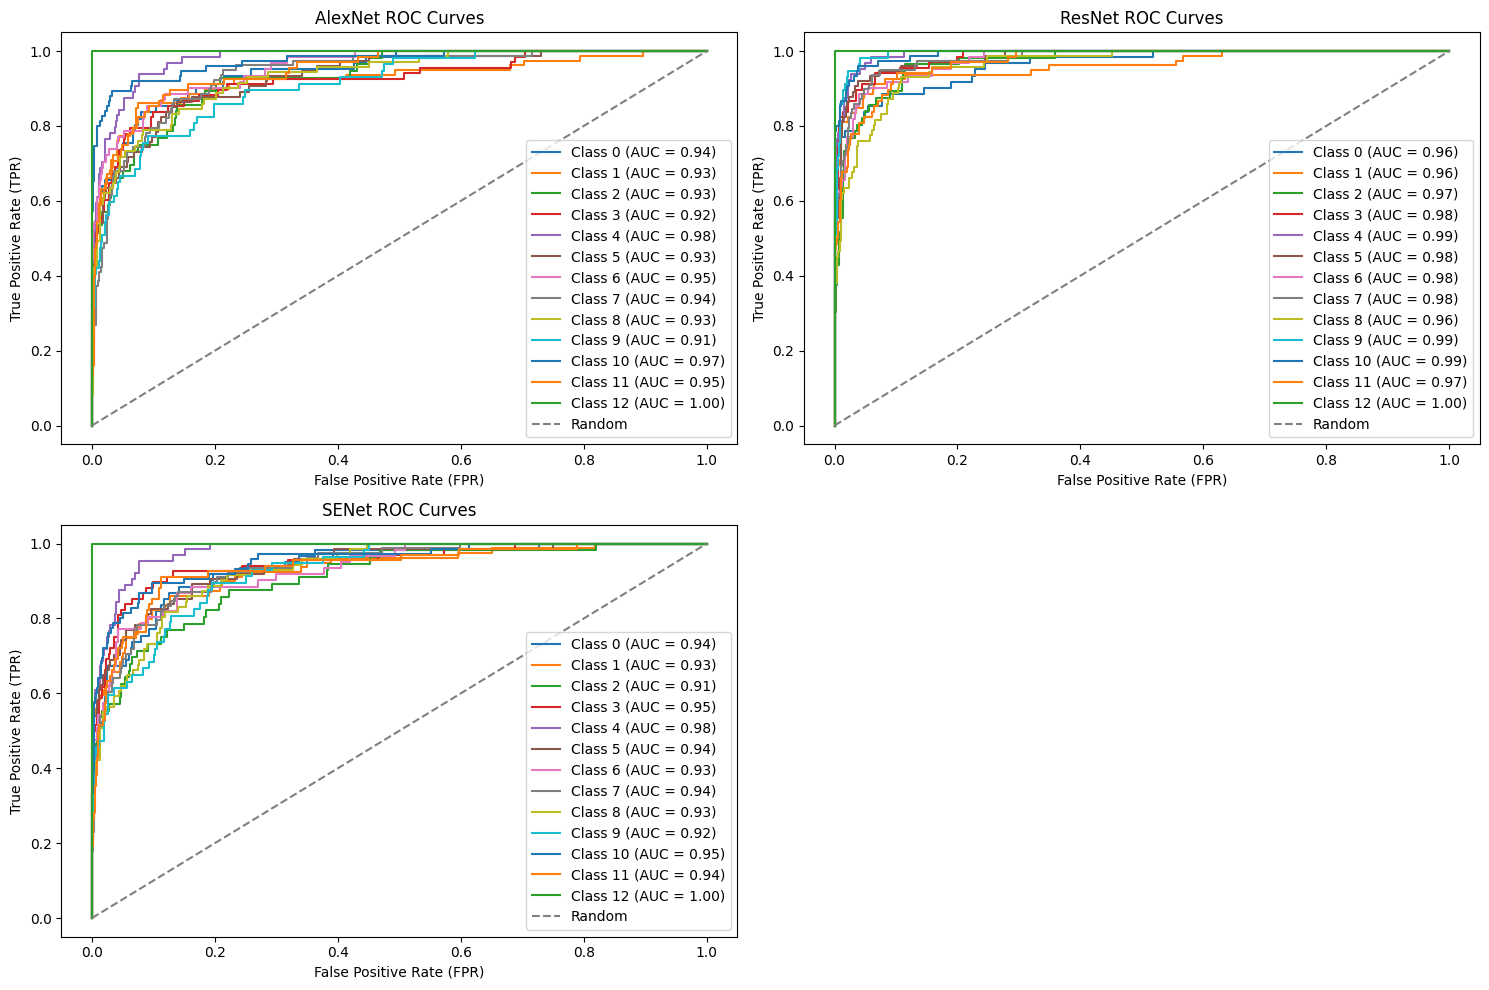

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to calculate the ROC curve and AUC for multiclass classification
def calculate_multiclass_roc_auc(model, features, true_labels, num_classes):
    true_labels_bin = label_binarize(true_labels, classes=range(num_classes))

    # Initialize variables to store FPR, TPR, and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    predictions = model.predict(features)

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

# Calculate ROC and AUC for each model
alexnet_fpr, alexnet_tpr, alexnet_roc_auc = calculate_multiclass_roc_auc(AlexNet_model, X_test, y_test, nClasses)
resnet_fpr, resnet_tpr, resnet_roc_auc = calculate_multiclass_roc_auc(resnet_model, X_test, y_test, nClasses)
senet_fpr, senet_tpr, senet_roc_auc = calculate_multiclass_roc_auc(senet_model, X_test, y_test, nClasses)

# Plot independent ROC curves for each class for each model
plt.figure(figsize=(15, 10))

# Plot ROC curve for each class for AlexNet
plt.subplot(2, 2, 1)
for i in range(nClasses):
    plt.plot(alexnet_fpr[i], alexnet_tpr[i], label=f'Class {i} (AUC = {alexnet_roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('AlexNet ROC Curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()

# Plot ROC curve for each class for ResNet
plt.subplot(2, 2, 2)
for i in range(nClasses):
    plt.plot(resnet_fpr[i], resnet_tpr[i], label=f'Class {i} (AUC = {resnet_roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ResNet ROC Curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()

# Plot ROC curve for each class for SENet
plt.subplot(2, 2, 3)
for i in range(nClasses):
    plt.plot(senet_fpr[i], senet_tpr[i], label=f'Class {i} (AUC = {senet_roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('SENet ROC Curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()

plt.tight_layout()
plt.show()


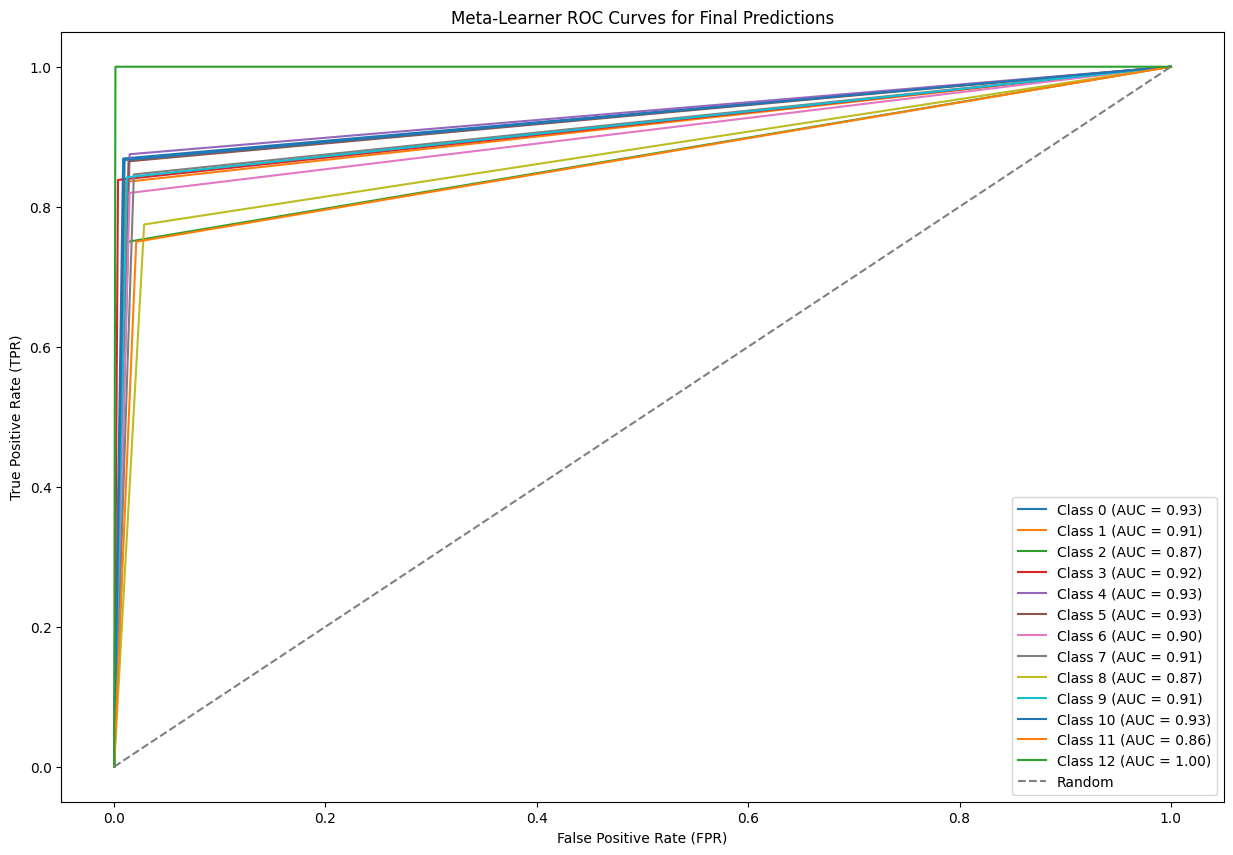

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to binary format
y_test_bin = label_binarize(y_test_classes, classes=range(nClasses))
final_predictions_bin = label_binarize(final_predictions_test_classes, classes=range(nClasses))

# Initialize variables to store FPR, TPR, and AUC for each class
fpr_final = dict()
tpr_final = dict()
roc_auc_final = dict()

# Calculate ROC and AUC for each class
for i in range(nClasses):
    fpr_final[i], tpr_final[i], _ = roc_curve(y_test_bin[:, i], final_predictions_bin[:, i])
    roc_auc_final[i] = auc(fpr_final[i], tpr_final[i])

# Plot independent ROC curves for each class for the final predictions
plt.figure(figsize=(15, 10))

for i in range(nClasses):
    plt.plot(fpr_final[i], tpr_final[i], label=f'Class {i} (AUC = {roc_auc_final[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Meta-Learner ROC Curves for Final Predictions')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()

plt.show()
